# Differential expression analysis (DEA)

In this notebook, I will do a differential expression analysis (DEA) on the expression data using the R-package `DESeq2`. First, I'll do this for only the samples from the beginning of the salmon sampling, i.e. day 0, and test difference in expression between feedstuff (MA: marine oil & VO: vegetable oil) and/or lifestage (freshwater/saltwater). 

Additionally, PCA and PLS-DA is also performed on the sub-dataset. PCA and PLS are two dimension reduction techniques, or projection methods, that aim to find linear combinations in feature space, the so-called principal components (PCs). Using an omics data table $\pmb{x}$, which is the feature space, PCA and PLS calculates linear combinations of the features, $w_1 x_1 + w_2 x_2 + ...w_n x_n = 0$, where $x_i$ is the value of gene/protein/metabolite $i$ (feature $i$). The size of $w_i$ shows the importance of feature $i$ in that PC. $w$’s are also called loadings.

PCA looks for a few linear combinations of the variables that can be used to summarise the data without losing too much information in the process. It is thus an unsupervised projection method with the goal of finding the direction in feature space with the largest variation. This results PC1. PC2 will be the direction in feature space that is orthogonal to PC1.

In addition to an omics data table $\pmb{x}$, PLS also uses information in a target variable/matrix $\pmb{y}$, which can either be continuous or discrete (i.e. Containing class labels. We thus have two forms of PLS, so-called PLS regression and PLS-DA (i.e. Discriminant analysis) for a continuous and discrete $\pmb{y}$ variable/matrix, respectively. The use of the target makes PLS supervised, and we can therefore think of it as supervised PCA. The aim of PLS is to find the multidimensional direction in $\pmb{x}$ space, (feature space) that explains the maximum multidimensional variance-direction (regression) or separation (classification) in the $\pmb{y}$ space.

As PLS is supervised, one need to be aware of overfitting. However, with PLS you can restrict or specify the number of PCs to use for prediction, so in this way PLS have a built-in feature selection, making it quite robust to overfitting.

## Prepare expression data

### Import modules and load salmon model

In [1]:
import cobra
import pandas as pd
import numpy as np
import os
from termcolor import colored

os.chdir('../../msc-hm')

# Load model
model = cobra.io.read_sbml_model('../salarecon/models/sasa/salarecon_bigg_curated.xml')

# Change lower bound for Biomass reaction to 1, 
# to demand it to carry flux in the creation of the context-specific models
# (for iMAT/INIT methods to include the biomass-related reactions)
model.reactions.Biomass.lower_bound = 1

Using license file /Users/Haavard/gurobi.lic
Academic license - for non-commercial use only - expires 2021-05-02


### Select only genes in the salmon model

In [2]:
# Read gene expression data as pandas dataframe
exprs = pd.read_csv('data/salmon_feed_switch.liver.counts.txt', 
                    sep='\t', header=0)


# Find indices in expression dataset of the genes in the model
mod_genes_idxs = [ind for ind, gene in enumerate(exprs.index) if gene.split(sep=':')[-1] in model.genes]

# Subset the data to only contain genes in the model
exprs = exprs.iloc[mod_genes_idxs, :]

# Move gene names in index to first column
exprs.reset_index(level=0, inplace=True)

In [3]:
exprs

index  5-D0-MA-L-3  6-D0-MA-L-4  7-D0-MA-L-8  8-D0-MA-L-9  \
0     gene10008:106603558           96           79          123          122   
1     gene10106:100194765          861         1043          620          415   
2     gene10123:100196673          832         1058          584          883   
3     gene10240:100194631           16           13           10            2   
4     gene10241:106603694            0            0            0            0   
...                   ...          ...          ...          ...          ...   
1104   gene9694:100195211          304          244          306          247   
1105   gene9710:106603157          745          651          641          559   
1106   gene9801:106603271        22019         5216         1426          952   
1107   gene9931:100195336          124          142          167          145   
1108   gene9938:100195484          268          243          114           97   

      73-D0-MA-L-1  74-D0-MA-L-2  75-D0-MA-L-7  76-D0-MA-L-6  17-D6-MA-L-1  \
0               51            51            61            61            81   
1              619           383           206           359           556   
2              594           408           392           498           677   
3                6             5             4             2             4   
4                0             0             0             0             1   
...            ...           ...           ...           ...           ...   
1104           223           170           141           232           236   
1105           361           407           275           309           328   
1106         10302         10345           754          2192          7504   
1107            94            67            68           150           111   
1108           143           138            68            70           261   

      ...  59-D9-VO-MA-L-T2-1  60-D9-VO-MA-L-T2-2  65-D16-VO-MA-L-T1-1  \
0     ...                  99                  89                   74   
1     ...                 517                 735                  531   
2     ...                 657                 740                  841   
3     ...                   5                   4                    3   
4     ...                   0                   0                    0   
...   ...                 ...                 ...                  ...   
1104  ...                 324                 301                  415   
1105  ...                 454                 485                  378   
1106  ...                 873                 534                 3339   
1107  ...                 139                 100                  170   
1108  ...                  39                  81                  264   

      66-D16-VO-MA-L-T1-2  67-D16-VO-MA-L-T2-1  68-D16-VO-MA-L-T2-2  \
0                      78                  122                   91   
1                     708                  705                  882   
2                    1025                  994                  953   
3                       7                   23                    2   
4                       0                    0                    0   
...                   ...                  ...                  ...   
1104                  358                  444                  403   
1105                  404                  389                  383   
1106                 2900                 1976                 9446   
1107                  117                  173                  137   
1108                  282                  633                  469   

      89-D20-VO-MA-L-T1-1  90-D20-VO-MA-L-T1-2  91-D20-VO-MA-L-T2-1  \
0                      75                   66                   71   
1                     397                  545                  499   
2                     738                  679                  669   
3                       1                    0                    2   
4            

## Perform the DEA using [R Magic](https://ipython.org/ipython-doc/2/config/extensions/rmagic.html)

### Data preparation

The table above is used as input to the R magic cell(s) below.

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R -i exprs

# Set working directory
setwd('~/Git/msc-hm')

# Import needed modules
suppressMessages(       # Silence messages
    paste(
        library(DESeq2),
        library(tidyverse),
        library(cowplot),
        library(plotly),
        library(Ssa.RefSeq.db),
        sep="")
)


# Get samples into vector to set them as column names
samples_all <- read.table(file = 'data/salmon_feed_switch.liver.CPM.txt',
                          header = FALSE, nrows = 1) %>% 
  as.character()



# Get gene IDs as vector
gns <- exprs$index
print(paste('Number of gene IDs:', length(gns))) # 1109
print(paste('Number of gene names:', length(get.genes(gns)$gene))) #1108

[1] "Number of gene IDs: 1109"
[1] "Number of gene names: 1108"


In [6]:
%%R

# Did some testing in RStudio, found out that the 132nd gene ID returns empty character string
print(gns[132])  # "gene1669:100196235"
get.genes(gns[132])$gene

[1] "gene1669:100196235"
character(0)


In [7]:
%%R -o genes_info

# Make genes info metadata table
genes_info <- get.genes(gns)

# Make empty row with unassociated gene
blank <- genes_info[1,]
blank[1, ] <- ""
blank[1, 1] <- gns[132]

# Bind rows to create full data frame and take a look
genes_info <- rbind(genes_info[1:131, ], blank, genes_info[132:nrow(genes_info), ]) %>% 
  magrittr::set_rownames(1:length(gns)) 


# Find duplicated gene names (No duplicated IDs when gene:number)
n_occur <- data.frame(table(genes_info$gene))
dups <- n_occur[n_occur$Freq > 1,]
dup_ids <- dups$Var1


# Add differentiating number to the duplicated gene names
for(gene in dup_ids){
  idx <- which(genes_info$gene == gene)
  for(i in 1:length(idx)){
    genes_info$gene[idx[i]] <- str_c(genes_info$gene[idx[i]], '_', i)
  }
}



head(as_tibble(genes_info))

# A tibble: 6 x 5
  gene_id        protein_id   gene     product                     gene_biotype 
  <chr>          <chr>        <chr>    <chr>                       <chr>        
1 gene10008:106… XP_01405288… acat1    acetyl-CoA acetyltransfera… protein_codi…
2 gene10106:100… NP_00113326… pgk      Phosphoglycerate kinase     protein_codi…
3 gene10123:100… NP_00113517… LOC1001… malate dehydrogenase 2-1%2… protein_codi…
4 gene10240:100… NP_00113318… ckm2     creatine kinase-2           protein_codi…
5 gene10241:106… XP_01405316… LOC1066… creatine kinase M-type-like protein_codi…
6 gene10307:106… XP_01405328… LOC1066… L-asparaginase-like         protein_codi…


In [8]:
%%R 

# Get count dataframe with gene IDs and names
df <- exprs %>%
  rename(geneID = index) %>%
  mutate(geneID = as.character(geneID),
         gene = genes_info$gene) %>%
  relocate(gene, .before = 2) %>%
  as.data.frame()

# Look at the data frame
head(as_tibble(df[, 1:5]))

# A tibble: 6 x 5
  geneID              gene         `5-D0-MA-L-3` `6-D0-MA-L-4` `7-D0-MA-L-8`
  <chr>               <chr>                <int>         <int>         <int>
1 gene10008:106603558 acat1                   96            79           123
2 gene10106:100194765 pgk                    861          1043           620
3 gene10123:100196673 LOC100196673           832          1058           584
4 gene10240:100194631 ckm2                    16            13            10
5 gene10241:106603694 LOC106603694             0             0             0
6 gene10307:106603750 LOC106603750            10            18             9


In [9]:
%%R

# Subset data based on selected sampling day
day <- 'D0'
day_num <- as.integer(str_extract(day, '[0-9]+'))
col_idx <- grep(day, colnames(df))

countData <- df[, col_idx]   # DESeq2 expects integers, so I round the data

# Look at the count data
head(as_tibble(countData))

# A tibble: 6 x 32
  `5-D0-MA-L-3` `6-D0-MA-L-4` `7-D0-MA-L-8` `8-D0-MA-L-9` `73-D0-MA-L-1`
          <int>         <int>         <int>         <int>          <int>
1            96            79           123           122             51
2           861          1043           620           415            619
3           832          1058           584           883            594
4            16            13            10             2              6
5             0             0             0             0              0
6            10            18             9            24             11
# … with 27 more variables: 74-D0-MA-L-2 <int>, 75-D0-MA-L-7 <int>,
#   76-D0-MA-L-6 <int>, 1-D0-VO-L-3 <int>, 2-D0-VO-L-4 <int>,
#   3-D0-VO-L-8 <int>, 4-D0-VO-L-9 <int>, 65-D0-VO-L-1 <int>,
#   66-D0-VO-L-2 <int>, 67-D0-VO-L-6 <int>, 68-D0-VO-L-7 <int>,
#   10-D0-MA-L-T1-2 <int>, 11-D0-MA-L-T1-3 <int>, 9-D0-MA-L-T1-1 <int>,
#   12-D0-MA-L-T1-4 <int>, 13-D0-MA-L-T2-1 <int>, 14-D0-MA-L-T2-2 <in

In [10]:
%%R

# Read and prepare metadata
meta <- read.table('data/salmon_feed_switch.sample_meta.txt') %>% 
  filter(tissue == 'liver', day == day_num) %>%                     # Filter on liver and day 0 
  mutate(feed = as.factor(feed), water = as.factor(water)) %>%      # Factorise feed type and water variables 
  `row.names<-`(., NULL) %>%
  column_to_rownames('sample')

# Look at metadata
head(as_tibble(meta))

# A tibble: 6 x 5
  water    tissue feed    day count.file                                        
  <fct>    <chr>  <fct> <int> <chr>                                             
1 freshwa… liver  MA        0 /mnt/SeqData3/GenoSysFat/processed_salmon_feed_sw…
2 freshwa… liver  MA        0 /mnt/SeqData3/GenoSysFat/processed_salmon_feed_sw…
3 freshwa… liver  MA        0 /mnt/SeqData3/GenoSysFat/processed_salmon_feed_sw…
4 freshwa… liver  MA        0 /mnt/SeqData3/GenoSysFat/processed_salmon_feed_sw…
5 freshwa… liver  MA        0 /mnt/SeqData3/GenoSysFat/processed_salmon_feed_sw…
6 freshwa… liver  MA        0 /mnt/SeqData3/GenoSysFat/processed_salmon_feed_sw…


In [11]:
%%R

## Define some variables for downstream analyses

# Get gene IDs as vector
genes_all <- df$gene

# Define count matrix
expr <- as.matrix(countData)
rownames(expr) <- genes_all

# Define sample names
samples_feed <- meta$feed
samples_water <- meta$water


# Define classes
classes_feed <- meta$feed
classes_water <- meta$water

### The Differential Expression Analysis

**<span style="color: red;">NB!</span>** After doing the DEA, I got reminded that the `DESeq2`-analysis requires raw counts, and not normalised counts like I was using. Therefore, the below differential expression analysis is not reliable or interpretable in any way, but I include it in case I get raw count data later on.


**<span style="color: red;">NB2!</span>** This is now done with raw count data!

Next, I define the object and run the differential expression analysis by using the `DESeq()`-function. This function performs a default analysis through the steps:
    
1. Estimation of size factors, where relative library depth of each sample is calculated.
2. Estimation of dispersion, where dispersion of counts for each gene are estimated. The dispersion is a parameter describing how much the variance deviates from the mean.
3. Negative Binomial GLM fitting and Wald statistics, where the significance of coefficients are calculated using the output from the previous steps.

`fitType = mean` use the mean of gene-wise dispersion estimates.



#### Some extra information about differential expression analysis with DESeq2: model fitting and hypothesis testing ([Ref](https://hbctraining.github.io/DGE_workshop_salmon/lessons/05_DGE_DESeq2_analysis2.html))

The final step in the `DESeq2` workflow is fitting the Negative Binomial model for each gene and performing differential expression testing.

Count data generated by RNA-seq, however, exhibits overdispersion (variance > mean) and the statistical distribution used to model the counts needs to account for this overdispersion. `DESeq2` uses a negative binomial distribution to model the RNA-seq counts using the equation below:

In [12]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://hbctraining.github.io/DGE_workshop_salmon/img/NB_model_formula.png", 
      width=700)

Modeling is a mathematically formalised way to approximate how the data behaves given a set of parameters (i.e. size factor, dispersion). `DESeq2` will use this formula as our model for each gene, and fit the normalised count data to it. After the model is fit, coefficients are estimated for each sample group along with their standard error. The coefficents are the estimates for the log2 foldchanges for each sample group.


##### Hypothesis testing

The first step in hypothesis testing is to set up a null hypothesis for each gene. In our case is, the null hypothesis is that there is no differential expression across the two sample groups (LFC == 0). Notice that we can do this without observing any data, because it is based on a thought experiment. Second, we use a statistical test to determine if based on the observed data, the null hypothesis is true.


##### Wald test

With `DESeq2`, the Wald test is the default used for hypothesis testing when comparing two groups. The Wald test is a test of hypothesis usually performed on parameters that have been estimated by maximum likelihood. In our case we are testing each gene model coefficient (LFC) which was derived using parameters like dispersion which were estimated using maximum likelihood.

`DESeq2` implements the Wald test by:

* Taking the LFC and dividing it by its standard error, resulting in a z-statistic
* The z-statistic is compared to a standard normal distribution, and a p-value is computed reporting the probability that a z-statistic at least as extreme as the observed value would be selected at random
* If the p-value is small we reject the null hypothesis and state that there is evidence against the null (i.e. the gene is differentially expressed).


##### Multiple test correction

`DESeq2` helps reduce the number of genes tested by removing those genes unlikely to be significantly DE prior to testing, such as those with low number of counts and outlier samples (gene-level QC). However, we still need to correct for multiple testing to reduce the number of false positives. An interpretation of the BH method for controlling the FDR is implemented in`DESeq` in which we rank the genes by p-value, then multiply each ranked p-value by m/rank.

>**So what does $FDR < 0.05$ mean?** By setting the FDR cutoff to $< 0.05$, we’re saying that the proportion of false positives we expect amongst our differentially expressed genes is $5\%$. For example, if you call $500$ genes as differentially expressed with an FDR cutoff of $0.05$, you expect $25$ of them to be false positives.

In [13]:
%%R

# Create dataframe with gene IDs as first column and the RNA-seq counts in other columns
data <- cbind(df$geneID, countData) %>% 
  rename(gene = `df$geneID`)



# Construct DESeqDataSet Object
suppressMessages(
    dds_feed <- DESeqDataSetFromMatrix(
        countData = data,
        colData = meta, 
        design = ~ feed, tidy = TRUE)
)

suppressMessages(
    dds_water <- DESeqDataSetFromMatrix(
      countData = data,
      colData = meta, 
      design = ~ water, tidy = TRUE)
)


# Change rownames from gene IDs to gene names
rownames(dds_feed) <- df$gene
rownames(dds_water) <- df$gene


# Run DESeq
suppressMessages(
    dds_feed <- DESeq(dds_feed, fitType = 'mean')
)

suppressMessages(
    dds_water <- DESeq(dds_water, fitType = 'mean'),
)

The `design`-argument specifies how the counts from each gene depend on our variables in the metadata. In this case, the factors we care about is feedstuff (`feed`) and lifestage (`water`). The `tidy`-argument specifies whether the first column of `countData` is the rownames for the count matrix, in this case it is.

The results of the analysis can then be extracted:

In [14]:
%%R

# Get results for feed type
res_feed_orig <- results(dds_feed)
summary(res_feed_orig, alpha = 0.05)


out of 1020 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 18, 1.8%
LFC < 0 (down)     : 24, 2.4%
outliers [1]       : 0, 0%
low counts [2]     : 177, 17%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



With an FDR-cutoff of $0.05$, there are $18$ upregulated and $24$ downregulated genes.

In [15]:
%%R

# Get results for water type
res_water_orig <- results(dds_water)
summary(res_water_orig, alpha = 0.05)


out of 1020 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 147, 14%
LFC < 0 (down)     : 150, 15%
outliers [1]       : 0, 0%
low counts [2]     : 79, 7.7%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



With an FDR-cutoff of $0.05$, there are $147$ upregulated and $150$ downregulated genes.

<br>

##### Shrunken log2 foldchanges (LFC)

To generate more accurate log2 foldchange estimates, `DESeq2` allows for the shrinkage of the LFC estimates toward zero when the information for a gene is low, which could include:

* Low counts
* High dispersion values

As with the shrinkage of dispersion estimates, LFC shrinkage uses information from all genes to generate more accurate estimates. Specifically, the distribution of LFC estimates for all genes is used (as a prior) to shrink the LFC estimates of genes with little information or high dispersion toward more likely (lower) LFC estimates.

In [16]:
Image(url= "https://hbctraining.github.io/DGE_workshop_salmon/img/deseq2_shrunken_lfc.png", width=500)

_The above illustration is from the [`DESeq2` paper](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0550-8)._

For example, in the figure above, the green gene and purple gene have the same mean values for the two sample groups (C57BL/6J and DBA/2J), but the green gene has little variation while the purple gene has high levels of variation. For the green gene with low variation, the unshrunken LFC estimate (vertex of the green solid line) is very similar to the shrunken LFC estimate (vertex of the green dotted line), but the LFC estimates for the purple gene are quite different due to the high dispersion. So even though two genes can have similar normalized count values, they can have differing degrees of LFC shrinkage. Notice the LFC estimates are shrunken toward the prior (black solid line).

To generate the shrunken log2 fold change estimates, you have to run an additional step on your results object (that we will create below) with the function `lfcShrink()`.

>**NOTE:** Shrinking the log2 fold changes will not change the total number of genes that are identified as significantly differentially expressed. The shrinkage of fold change is to help with downstream assessment of results.


In [17]:
%%R
suppressMessages(
    res_feed <- lfcShrink(dds_feed, coef='feed_VO_vs_MA', res=res_feed_orig)  
)
suppressMessages(
    res_water <- lfcShrink(dds_water, coef='water_saltwater_vs_freshwater', res=res_water_orig)
)


By subsetting the results table, I can extract only the significant DEGs ($FDR < 0.05$ and $|log_{2}FC| > 1$):

In [18]:
%%R -o degs_feed

res_feed.sig <- subset(res_feed, subset = (padj < 0.05 & abs(log2FoldChange) > 1)) 
res_feed.sig <- res_feed.sig[order(res_feed.sig$padj),]
degs_feed <- rownames(res_feed.sig)

res_feed.sig

log2 fold change (MAP): feed VO vs MA 
Wald test p-value: feed VO vs MA 
DataFrame with 2 rows and 5 columns
              baseMean log2FoldChange     lfcSE      pvalue        padj
             <numeric>      <numeric> <numeric>   <numeric>   <numeric>
LOC106571543   3372.50        1.32731  0.301918 5.24012e-07 0.000220871
aacs           5586.03        1.04946  0.487947 9.43032e-04 0.033124001


By looking at the adjusted p-values (`padj`), we can see that some genes are highly significantly differentially expressed (in this case between the feed types).

In [19]:
degs_feed_info = genes_info[genes_info.gene.isin(degs_feed)]
degs_feed_info

gene_id      protein_id          gene  \
434   gene3028:106571543  XP_014000178.1  LOC106571543   
822  gene47168:106585920  XP_014028138.1          aacs   

                                               product    gene_biotype  
434  hydroxymethylglutaryl-CoA synthase%2C cytoplas...  protein_coding  
822                         acetoacetyl-CoA synthetase  protein_coding

In [20]:
for i, g in enumerate(degs_feed):
    print(colored(f'Gene: ID {degs_feed_info.gene_id[i]}, Name {g}', color='blue', attrs = ['bold', 'underline']))
    print(colored(f'The product of this gene is:', color='red', attrs = ['bold', 'underline']))
    print(degs_feed_info["product"][i])
    print()

Gene: ID gene3028:106571543, Name LOC106571543
The product of this gene is:
hydroxymethylglutaryl-CoA synthase%2C cytoplasmic-like

Gene: ID gene47168:106585920, Name aacs
The product of this gene is:
acetoacetyl-CoA synthetase



In [21]:
%%R -o degs_water

res_water.sig <- subset(res_water, subset = (padj < 0.05 & abs(log2FoldChange) > 1)) 
res_water.sig <- res_water.sig[order(res_water.sig$padj),]
degs_water <- rownames(res_water.sig)

res_water.sig

log2 fold change (MAP): water saltwater vs freshwater 
Wald test p-value: water saltwater vs freshwater 
DataFrame with 58 rows and 5 columns
              baseMean log2FoldChange     lfcSE      pvalue        padj
             <numeric>      <numeric> <numeric>   <numeric>   <numeric>
LOC106592407 1338.3131       -1.20511  0.108462 9.22491e-30 8.68064e-27
LOC106592516  181.4944       -1.22088  0.136014 2.42147e-20 5.69651e-18
LOC106580183 9063.6744       -1.41254  0.163777 4.50071e-19 8.47034e-17
LOC106560331   20.9068        2.84014  0.331769 5.58715e-19 8.76251e-17
LOC106569991  850.2205       -2.24319  0.271236 6.66526e-18 8.96002e-16
...                ...            ...       ...         ...         ...
LOC106571948  2.261663       -1.64242  1.255538  0.00457681   0.0189726
pck1         11.161684        1.40176  1.106139  0.00460891   0.0190219
p4ha3         0.628944        2.62811  1.510510  0.00561436   0.0221980
LOC106573215  0.679029       -1.70017  1.365964  0.00585296   0.02

By looking at the adjusted p-values (`padj`), we can see that some genes are highly significantly differentially expressed (in this case between the water types).

In [22]:
degs_water_info = genes_info[genes_info.gene.isin(degs_water)]
degs_water_info.head()

gene_id      protein_id          gene  \
19    gene1103:106605019  XP_014055720.1  LOC106605019   
27   gene11509:106604855  XP_014055393.1  LOC106604855   
36   gene11992:100194593  XP_014056152.1         nt5c3   
107   gene1567:106610271  XP_014065012.1  LOC106610271   
111  gene15897:106608992  XP_014062784.1  LOC106608992   

                                       product    gene_biotype  
19   cysteine sulfinic acid decarboxylase-like  protein_coding  
27       fructose-bisphosphate aldolase B-like  protein_coding  
36            5'-nucleotidase%2C cytosolic III  protein_coding  
107                   fatty acid synthase-like  protein_coding  
111       purine nucleoside phosphorylase-like  protein_coding

In [23]:
for i, g in enumerate(degs_water):
    print(colored(f'Gene: ID {degs_water_info.gene_id[i]}, Name {g}', color='blue', attrs = ['bold', 'underline']))
    print(colored(f'The product of this gene is:', color='red', attrs = ['bold', 'underline']))
    print(degs_water_info["product"][i])
    print()

Gene: ID gene1103:106605019, Name LOC106592407
The product of this gene is:
cysteine sulfinic acid decarboxylase-like

Gene: ID gene11509:106604855, Name LOC106592516
The product of this gene is:
fructose-bisphosphate aldolase B-like

Gene: ID gene11992:100194593, Name LOC106580183
The product of this gene is:
5'-nucleotidase%2C cytosolic III

Gene: ID gene1567:106610271, Name LOC106560331
The product of this gene is:
fatty acid synthase-like

Gene: ID gene15897:106608992, Name LOC106569991
The product of this gene is:
purine nucleoside phosphorylase-like

Gene: ID gene17683:106610734, Name LOC106580620
The product of this gene is:
phosphatidate phosphatase LPIN1-like

Gene: ID gene18007:100195654, Name LOC106589763
The product of this gene is:
Creatine kinase%2C testis isozyme

Gene: ID gene1950:106560439, Name LOC106562750
The product of this gene is:
pyruvate carboxylase%2C mitochondrial-like

Gene: ID gene19916:106612801, Name LOC106560439
The product of this gene is:
carbonic anhy

### Plotting

From the DEA-results I can make a couple of plots to highlight them.

#### Counts

The `plotCounts()` function can be used to compare the normalised counts between the groups of interest for $n$ genes.

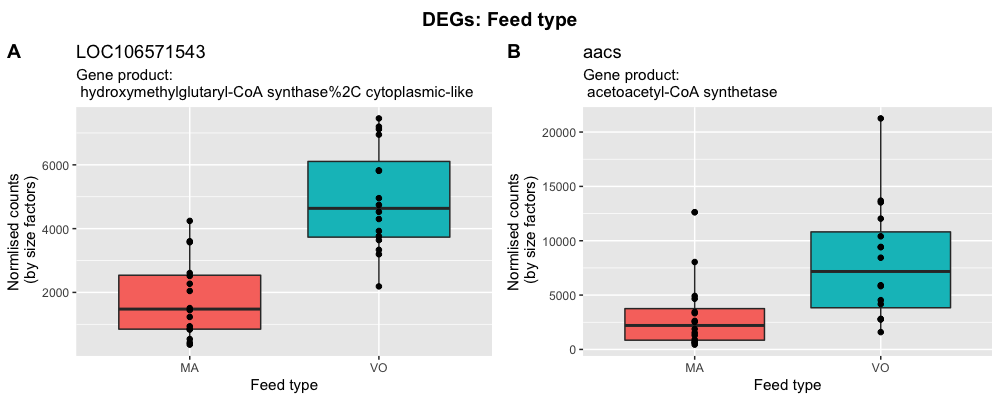

In [24]:
%%R -w 10 -h 4 -u in -r 100

nrows = 1
ncols = 2
n_genes = nrows*ncols


# Iterate over genes and plot their counts
l <- vector("list", n_genes)
i <- 1
for(gene in degs_feed[1:n_genes]){
    gene_product <-  genes_info[which(genes_info$gene == gene), 'product']
    l[[i]] <- plotCounts(dds_feed, gene=gene, 
             intgroup="feed", returnData = TRUE) %>% 
    ggplot() + 
    geom_boxplot(aes(x=feed, y=count, fill=feed), show.legend = FALSE) +
    geom_point(aes(x=feed, y=count)) + 
    labs(title=gene, subtitle=paste('Gene product:\n', gene_product), 
         x = "Feed type", y = "Normlised counts\n (by size factors)")
  
  i <- i+1
}

names(l) <- paste("p", 1:length(l), sep = "")
list2env(l , envir = .GlobalEnv)

plots <- plot_grid(plotlist = l, labels = 'AUTO', ncol = ncols, nrow = nrows)


# Set plot title
title <- ggdraw() + draw_label("DEGs: Feed type", fontface='bold')

plot_grid(title, plots, ncol=1, rel_heights=c(0.1, 1)) # rel_heights values control title margins

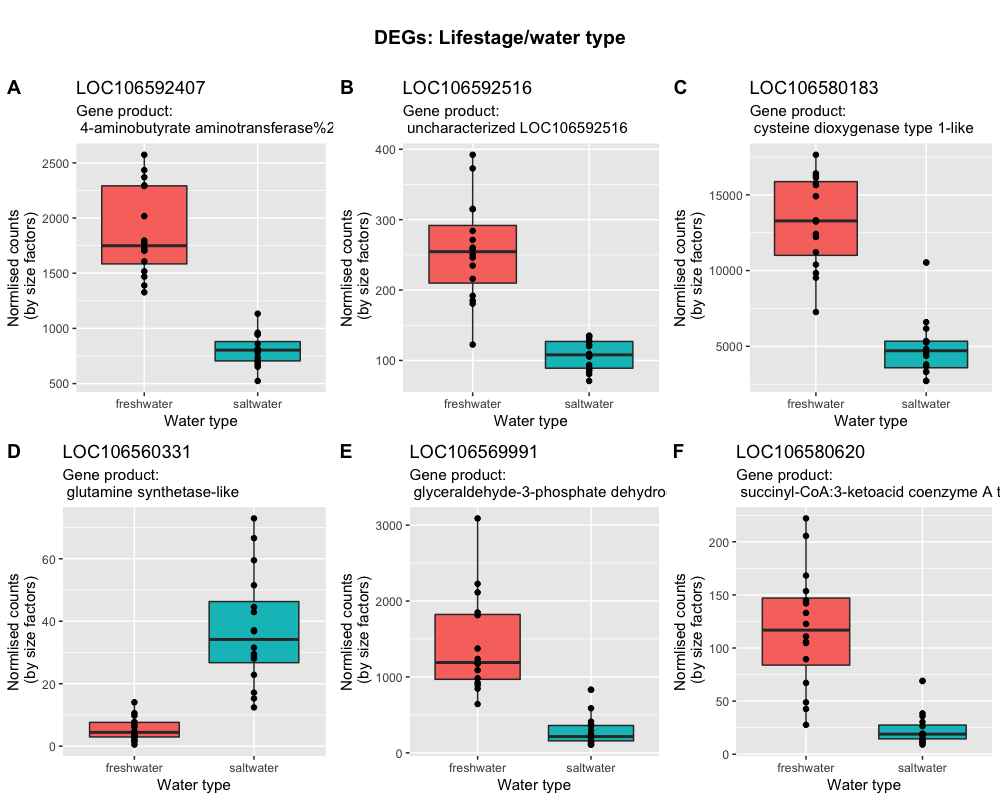

In [25]:
%%R -w 10 -h 8 -u in -r 100

nrows = 2
ncols = 3
n_genes = nrows*ncols


# Iterate over genes and plot their counts
l <- vector("list", n_genes)
i <- 1
for(gene in degs_water[1:n_genes]){
  gene_product <-  genes_info[which(genes_info$gene == gene), 'product']
  l[[i]] <- plotCounts(dds_water, gene=gene, 
                       intgroup="water", returnData = TRUE) %>% 
    ggplot() + 
    geom_boxplot(aes(x=water, y=count, fill=water), show.legend = FALSE) +
    geom_point(aes(x=water, y=count)) + 
    labs(title=gene, subtitle=paste('Gene product:\n', gene_product), 
         x = "Water type", y = "Normlised counts\n (by size factors)")
  
  i <- i+1
}

names(l) <- paste("p", 1:length(l), sep = "")
list2env(l , envir = .GlobalEnv)

plots <- plot_grid(plotlist = l, labels = 'AUTO', ncol = ncols, nrow = nrows)


# Set plot title
title <- ggdraw() + draw_label("DEGs: Lifestage/water type", fontface='bold')

plot_grid(title, plots, ncol=1, rel_heights=c(0.1, 1)) # rel_heights values control title margins

#### Volcano plot

A volcano plot is a type of scatterplot that shows statistical significance (p-value) versus magnitude of change (fold change). It enables quick visual identification of genes with large fold changes that are also statistically significant. These may be the most biologically significant genes. In a volcano plot, the most upregulated genes are towards the right, the most downregulated genes are towards the left, and the most statistically significant genes are towards the top. ([Ref](https://galaxyproject.github.io/training-material/topics/transcriptomics/tutorials/rna-seq-viz-with-volcanoplot/tutorial.html))

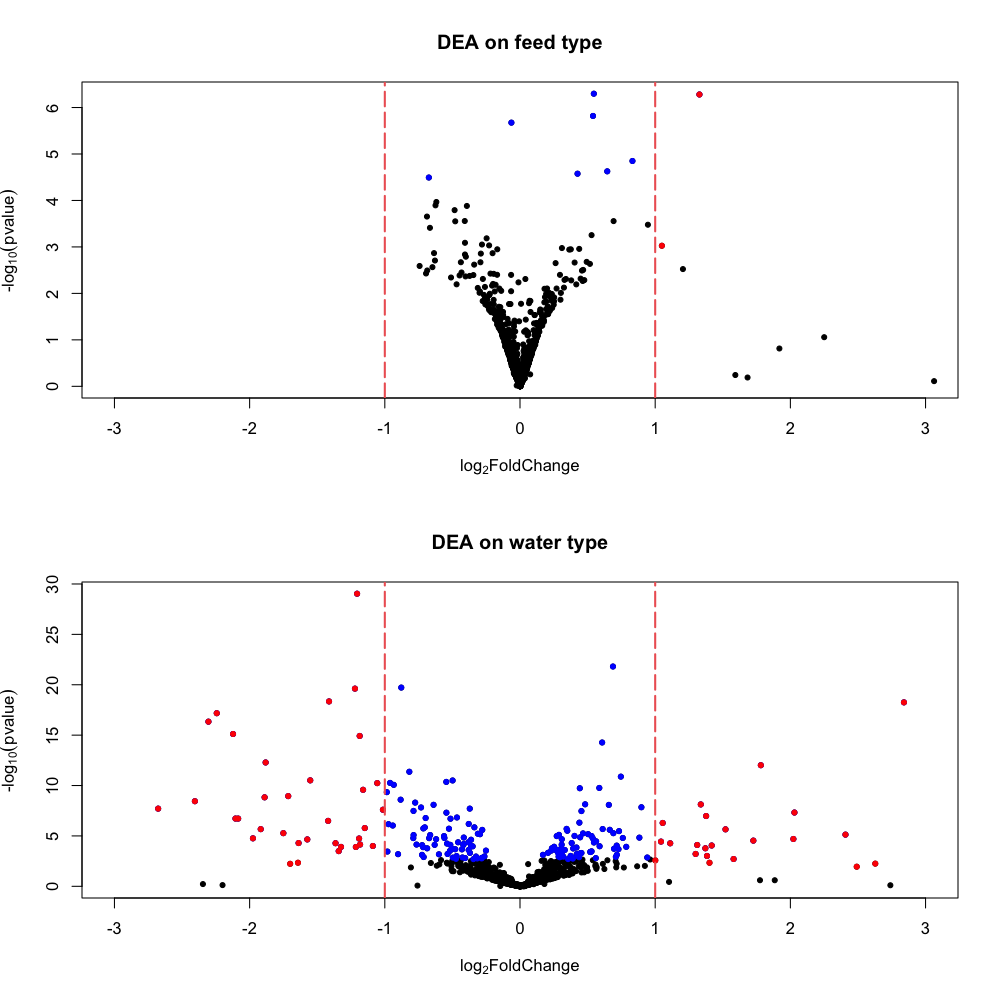

In [26]:
%%R -w 10 -h 10 -u in -r 100

# Reset graphical parameters
par(mfrow=c(2,1), mar=c(5, 4, 4, 2) + 0.1) #Default mar value

# Make a basic volcano plot
with(res_feed, plot(log2FoldChange, -log10(pvalue), 
               ylab=expression(paste('-log'[10], (pvalue), sep="")),
               xlab=expression(paste('log'[2], 'FoldChange')),
               pch=20, main="DEA on feed type", xlim=c(-3,3)))

# Add colored points: blue if padj<0.01, red if abs(log2FC)>1 and padj<0.05)
with(subset(res_feed, padj<.01 ), 
     points(log2FoldChange, -log10(pvalue), pch=20, col="blue"))
with(subset(res_feed, padj<.05 & abs(log2FoldChange)>1), 
     points(log2FoldChange, -log10(pvalue), pch=20, col="red"))

# Add vertical line of log2FC cut-off
abline(v = c(-1, 1), col="indianred2", lwd=2, lty=5)



#### WATER TYPE

# Make a basic volcano plot
with(res_water, plot(log2FoldChange, -log10(pvalue), 
                    ylab=expression(paste('-log'[10], (pvalue), sep="")),
                    xlab=expression(paste('log'[2], 'FoldChange')),
                    pch=20, main="DEA on water type", xlim=c(-3,3)))

# Add colored points: blue if padj<0.01, red if abs(log2FC)>1 and padj<0.05)
with(subset(res_water, padj<.01 ), 
     points(log2FoldChange, -log10(pvalue), pch=20, col="blue"))
with(subset(res_water, padj<.05 & abs(log2FoldChange)>1), 
     points(log2FoldChange, -log10(pvalue), pch=20, col="red"))

# Add vertical line of log2FC cut-off
abline(v = c(-1, 1), col="indianred2", lwd=2, lty=5)

The figure shows the volcano plots, where I have coloured genes with an adjusted p-value $< 0.01$ as blue, while I have a bit less stringent adjusted p-value threshold for the red points ($< 0.05$), but with a threshold for the absolute value of its log$_{2}$ fold change value ($> 1$). I also have added a vertical line for the threshold value to make it more clear. This means that genes in red are significantly differentially expressed and up- or downregulated, while genes in blue are only significantly differentially expressed.

#### MA plot

An MA plot gives a good visual overview of the DEA results. For each gene (point) the mean expression level is plotted against the log2 FC. The horizontal line at log2 FC = 0 indicates that there is no change in expression. Genes highlighted in blue are significant DEGs according to the cut-off, i.e. $FDR < 0.05$. Genes in grey are not differentially expressed.

One thing that is not shown in MA plots is the variance. So for non-DEGs which have higher fold-change than DEGs probably have higher variance, making them not significant.

With count the data, the power increases fast. This is because lower fold change is statistically significant for genes with higher expression, and that the noise associated with discrete read counts (shot noise) decreases with more reads. In other words, if a gene is lowly expressed, it will result in very few reads. This makes it difficult to be sure whether or not a that gene is actually significant and differentially expressed.

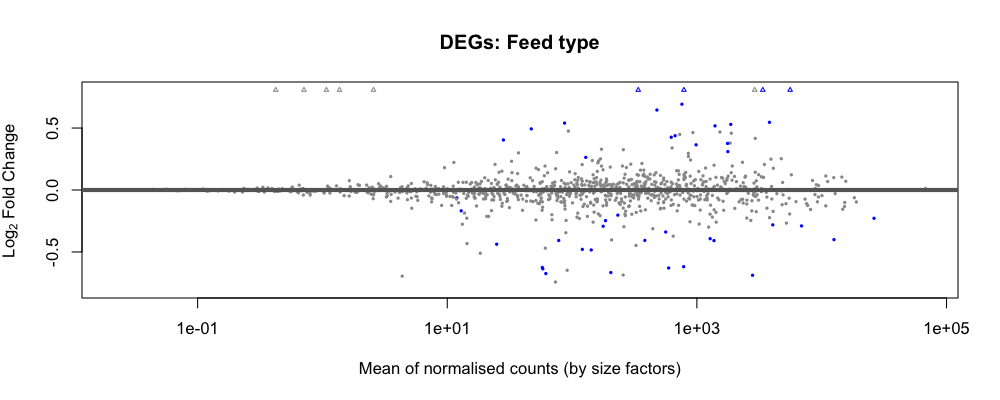

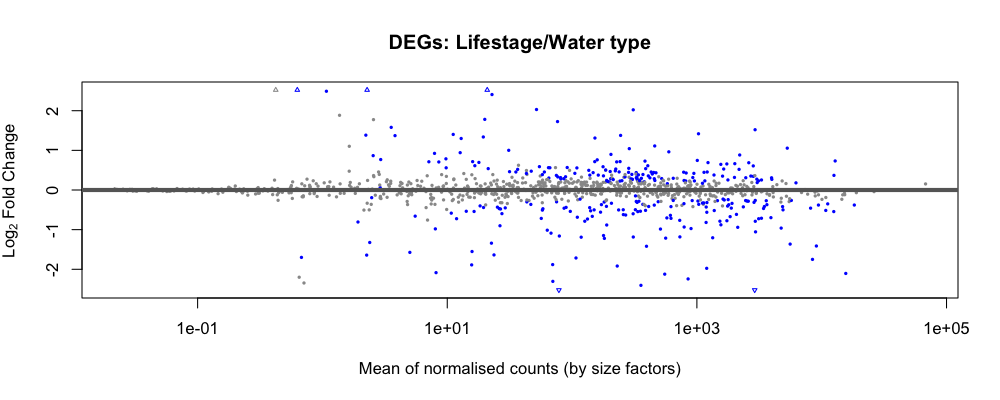

In [27]:
%%R -w 10 -h 4 -u in -r 100

# Making the MA-plots
plotMA(res_feed, alpha = 0.05, main='DEGs: Feed type',
       xlab='Mean of normalised counts (by size factors)', 
       ylab=expression(paste('Log'[2], ' Fold Change')))


plotMA(res_water, alpha = 0.05, main='DEGs: Lifestage/Water type',
       xlab='Mean of normalised counts (by size factors)', 
       ylab=expression(paste('Log'[2], ' Fold Change')))

### PCA

With multidimensional data like gene expression data, PCA is a useful tool for dimension reduction. However, first I have to normalise the data.

A simple, but important, normalisation step is to account for library sizes. Since you sequence at different depths, the samples that were sequenced the deepest would have more reads than the other one. And if you don’t account for this, the deepest sequenced sample would portray a higher expression level, although the expression levels are actually the same. Consequently, it is crucial to account for library sizes in the normalisation step.

In `DESeq` we can normalize for library size using the `estimateSizeFactors()` function. By doing this normalisation step, the sample median values becomes a lot more similar. Generally, samples with high expression values are scaled down and vice versa for samples with low expression values. This is a between-sample normalisation method.

Another method for normalizing is the **variance stabilizing transformation (VST)**. The goal of VST is to make sure that the expression values are independent from their mean values. In `DESeq2`, this normalisation method is implemented in the `varianceStabilizingTransformation()` function. The Variance Stabilising Transformation gets rid of dependency between expression value and variance. Often, highly expressed genes are more variable and VST gets rid of this. VST is in practice, basically a log2-transformation, but differs in how lowly expressed genes are transformed. Now the variability of the expression values are not related to their mean value, so that the variance between samples are more similar, as implied by the name of this method. 

Below I use VST to normalise the data between samples, to use for the downstream PCA.

In [28]:
%%R

# Normalise the data
vsd <- varianceStabilizingTransformation(dds_feed, fitType = 'mean')

This function calculates a variance stabilizing transformation (VST) from the fitted dispersion-mean relations and then transforms the count data to a log-like scale (normalized by division by the size factors or normalization factors), yielding a matrix of values which are now approximately homoskedastic (having constant variance along the range of mean values). The transformation also normalises with respect to library size. VST, in practice, is basically a log$_2$-transformation, but differs in how lowly expressed genes are transformed. After the transformation, the variability of the expression values are not related to their mean value, so that the variance between samples are more similar, as implied by the name of this method. 

Now that the data are normalised between samples as well, I can continue with the analysis.


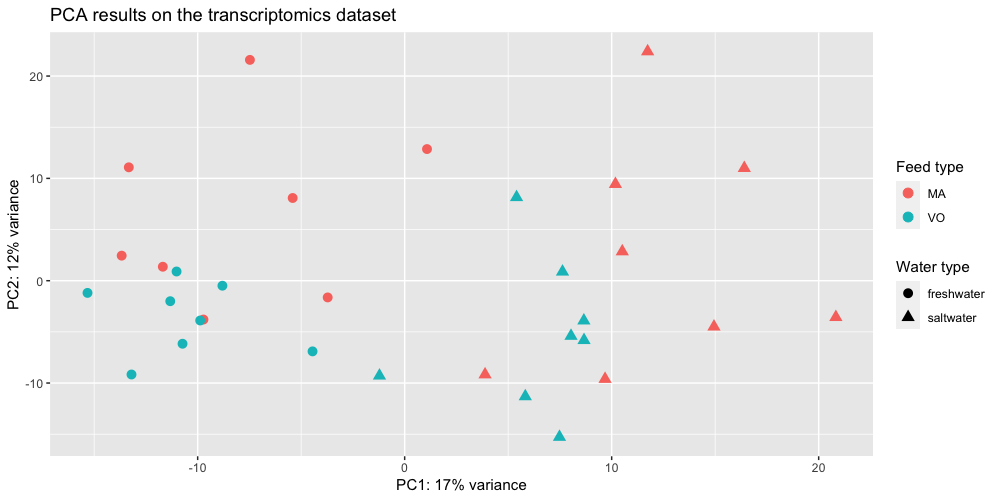

In [29]:
%%R -w 10 -h 5 -u in -r 100

# Get the normalised data
vsd.counts <- assay(vsd)


# Create data frame for performing the PCA
d <- cbind(classes_feed, classes_water, 
                as.data.frame(t(vsd.counts))) %>% 
  rename("Feed" = classes_feed,
         "Water" = classes_water)


# Perform the PCA
pca <- prcomp(t(vsd.counts))

# How much variance is explained by the PCs?
eigs <- pca$sdev^2
var_expl <- eigs / sum(eigs)


# Plotting the PCA results
d_pca <- data.frame(Feed=d$Feed, Water=d$Water, pca$x)

ggplot(d_pca, aes(x=PC1, y=PC2, colour=Feed, shape=Water)) +
  geom_point(size=3) +
  labs(title="PCA results on the transcriptomics dataset",
       x = paste0('PC1: ', round(var_expl[1], 2)*100,'% variance'),
       y = paste0('PC2: ', round(var_expl[2], 2)*100,'% variance'),
       colour='Feed type', shape='Water type')

From the PCA plot, we can see that feed type have larger variance on PC1 than water type. Water type is actually separable on this PC, while a seperation of feed types is impossible here.


The top 5 most important genes for these two principal components can then be found through the `rotation` table of the `pca`-object.

In [30]:
%%R

# Most important genes for PC1
pc1_genes <- names(sort(pca$rotation[, 1], decreasing=TRUE)[1:5])

# Extract information about these genes
pc1_genes_info <- genes_info %>% 
  filter(gene %in% pc1_genes) %>% 
  select(gene, product) %>% 
  mutate(PC = "PC1")

# Most important genes for PC2
pc2_genes <- names(sort(pca$rotation[, 2], decreasing=TRUE)[1:5])

# Extract information about these genes
pc2_genes_info <- genes_info %>% 
  filter(gene %in% pc2_genes) %>% 
  select(gene, product) %>% 
  mutate(PC = "PC2")

# Bind the two tables together
pca_genes <- as_tibble(bind_rows(pc1_genes_info, pc2_genes_info))
pca_genes

# A tibble: 10 x 3
   gene        product                                                     PC   
   <chr>       <chr>                                                       <chr>
 1 LOC1065603… glutamine synthetase-like                                   PC1  
 2 LOC1065711… adenylate kinase 7-like                                     PC1  
 3 LOC1065852… bifunctional methylenetetrahydrofolate dehydrogenase/cyclo… PC1  
 4 LOC1065862… D-3-phosphoglycerate dehydrogenase-like                     PC1  
 5 entpd5      ectonucleoside triphosphate diphosphohydrolase 5            PC1  
 6 LOC1066039… carbonic anhydrase 4-like                                   PC2  
 7 LOC1066089… purine nucleoside phosphorylase-like                        PC2  
 8 LOC1065708… probable bifunctional methylenetetrahydrofolate dehydrogen… PC2  
 9 LOC1065893… glucose-6-phosphatase-like                                  PC2  
10 LOC1066005… alcohol dehydrogenase 1-like                                PC2  


### PLS-DA

To check whether the feed and water types can be separated by the samples, I perform a PLS-DA.

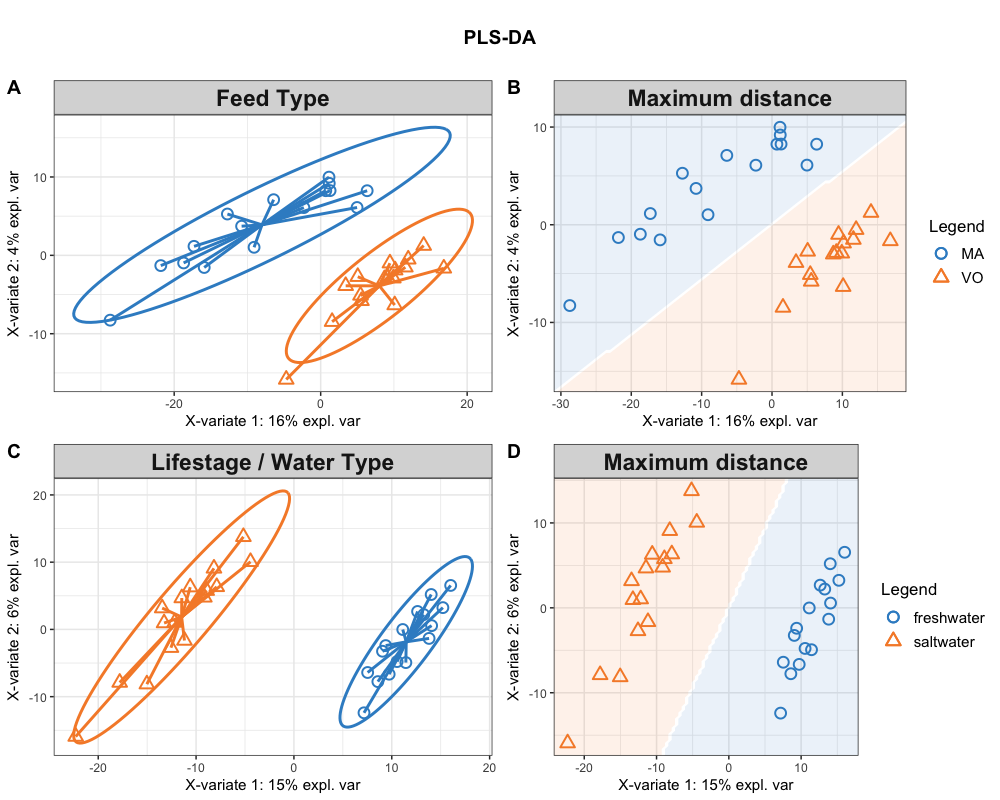

In [31]:
%%R -w 10 -h 8 -u in -r 100

# Package needed for the PLS-DA functions and consequent plotting
suppressMessages(
    library(mixOmics)
)

# Perform the PLS-DA
expr_feed.plsda <- plsda(t(vsd.counts), classes_feed, ncomp=2)
expr_water.plsda <- plsda(t(vsd.counts), classes_water, ncomp=2)


# Define function for suppressing plot creation when calling plot function
# Define function for saving plots without sending it to current graphics device
# From: https://stackoverflow.com/questions/20363266/how-can-i-suppress-the-creation-of-a-plot-while-calling-a-function-in-r
plotIndiv.invisible <- function(...){
  ff <- tempfile()
  png(filename=ff)
  res <- plotIndiv(...)
  dev.off()
  unlink(ff)
  res
}


# Plotting the results of the PLS-DA
p1_feed <- plotIndiv.invisible(expr_feed.plsda, ind.names = FALSE, legend=FALSE,
          ellipse = TRUE, star = TRUE, title = "Feed Type")


# Calculating a 'prediction' background surface first, before overlaying the sample plot afterwards.
background_feed <- background.predict(expr_feed.plsda, comp.predicted=2,
                                 dist = "max.dist") 
p2_feed <- plotIndiv.invisible(expr_feed.plsda, comp = 1:2, group = classes_feed,
          ind.names = FALSE, title = "Maximum distance",
          legend = TRUE,  background = background_feed)


# Plotting the results of the PLS-DA
p1_water <- plotIndiv.invisible(expr_water.plsda, ind.names = FALSE, legend=FALSE,
          ellipse = TRUE, star = TRUE, title = "Lifestage / Water Type")


# Calculating a 'prediction' background surface first, before overlaying the sample plot afterwards.
background_water <- background.predict(expr_water.plsda, comp.predicted=2,
                                 dist = "max.dist") 
p2_water <- plotIndiv.invisible(expr_water.plsda, comp = 1:2, group = classes_water,
          ind.names = FALSE, title = "Maximum distance",
          legend = TRUE,  background = background_water)


l <- list(p1_feed$graph, p2_feed$graph, p1_water$graph, p2_water$graph)

plots <- plot_grid(plotlist = l, labels = 'AUTO', 
                   nrow = 2, ncol = 2)


# Set plot title
title <- ggdraw() + draw_label("PLS-DA", fontface='bold')

plot_grid(title, plots, ncol=1, rel_heights=c(0.1, 1)) # rel_heights values control title margins

From the sample plot, I observe a clear separation of the two feed types compared to an unsupervised PCA sample plot. Confidence ellipses for each class are plotted to highlight the strength of the discrimination (confidence level set to $95\%$ by default, see argument `ellipse.level`).

The prediction area is visualised by calculating a background surface first, before overlaying the sample plot. 

The plots visualises the results of the PLS-DA models. The models seem to be able to separate both the different feed and water types very successfully. To compare with the PCA results above, I find the top 5 most important genes for these two principal components through the `X` table of the `loadings`-object of the `plsda`-objects.

In [32]:
%%R

pls1_genes <- names(sort(expr_feed.plsda$loadings$X[, 1], decreasing=TRUE)[1:5])

# Extract information about these genes
pls1_genes_info <- genes_info %>% 
  filter(gene %in% pls1_genes) %>% 
  dplyr::select(gene, product) %>% 
  mutate(PC = "PC1")

pls2_genes <- names(sort(expr_feed.plsda$loadings$X[, 2], decreasing=TRUE)[1:5])

# Extract information about these genes
pls2_genes_info <- genes_info %>% 
  filter(gene %in% pls2_genes) %>% 
  dplyr::select(gene, product) %>% 
  mutate(PC = "PC2")

# Bind the two tables together
plsda_genes <- as_tibble(bind_rows(pls1_genes_info, pls2_genes_info))
plsda_genes

# A tibble: 10 x 3
   gene         product                                                PC   
   <chr>        <chr>                                                  <chr>
 1 LOC106605166 persulfide dioxygenase ETHE1%2C mitochondrial-like     PC1  
 2 LOC106612829 phosphoserine phosphatase-like                         PC1  
 3 acaca        acetyl-CoA carboxylase alpha                           PC1  
 4 LOC106571543 hydroxymethylglutaryl-CoA synthase%2C cytoplasmic-like PC1  
 5 LOC106586335 isocitrate dehydrogenase [NADP] cytoplasmic-like       PC1  
 6 LOC106604323 ribose-phosphate pyrophosphokinase 1-like              PC2  
 7 nagk         N-acetylglucosamine kinase                             PC2  
 8 nt5m         5'%2C3'-nucleotidase%2C mitochondrial                  PC2  
 9 dnm1l        dynamin 1-like                                         PC2  
10 LOC106585165 glycerol-3-phosphate acyltransferase 3-like            PC2  


In [33]:
%%R

pca_genes

# A tibble: 10 x 3
   gene        product                                                     PC   
   <chr>       <chr>                                                       <chr>
 1 LOC1065603… glutamine synthetase-like                                   PC1  
 2 LOC1065711… adenylate kinase 7-like                                     PC1  
 3 LOC1065852… bifunctional methylenetetrahydrofolate dehydrogenase/cyclo… PC1  
 4 LOC1065862… D-3-phosphoglycerate dehydrogenase-like                     PC1  
 5 entpd5      ectonucleoside triphosphate diphosphohydrolase 5            PC1  
 6 LOC1066039… carbonic anhydrase 4-like                                   PC2  
 7 LOC1066089… purine nucleoside phosphorylase-like                        PC2  
 8 LOC1065708… probable bifunctional methylenetetrahydrofolate dehydrogen… PC2  
 9 LOC1065893… glucose-6-phosphatase-like                                  PC2  
10 LOC1066005… alcohol dehydrogenase 1-like                                PC2  


The top 5 most important genes of the first two principal components of both the PCA and PLS-DA results can be seen above. The most important genes of the PCA results is not seen in the PLS-DA results.


### Area Under the Curve and Reciever Operating Characteristic (AUROC)

AUROC is a performance metric for “discrimination”: it tells you about a model’s ability to discriminate between cases (positive examples) and non-cases (negative examples). An AUROC of $0.8$ means that the model has good discriminatory ability: $80\%$ of the time, the model will correctly assign a higher absolute risk to a randomly selected patient with a particular cancer type than to a randomly selected patient without this cancer type.

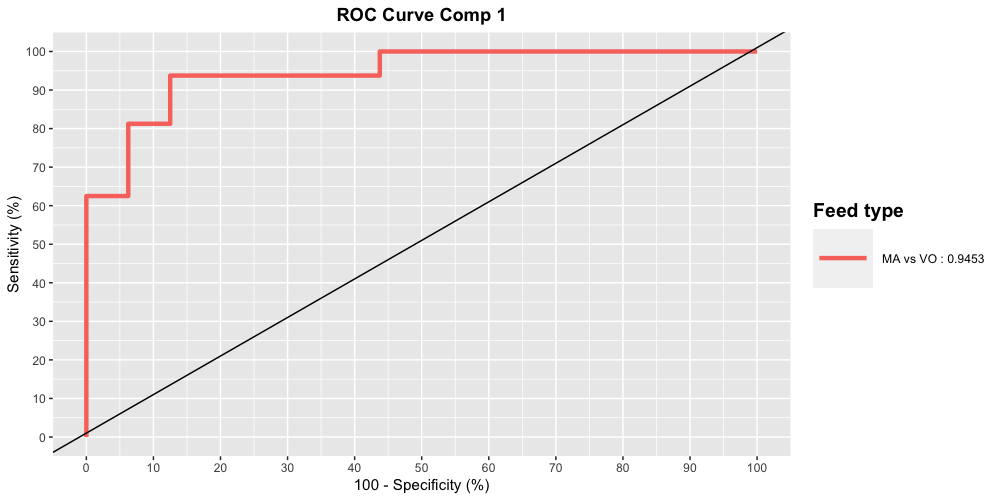

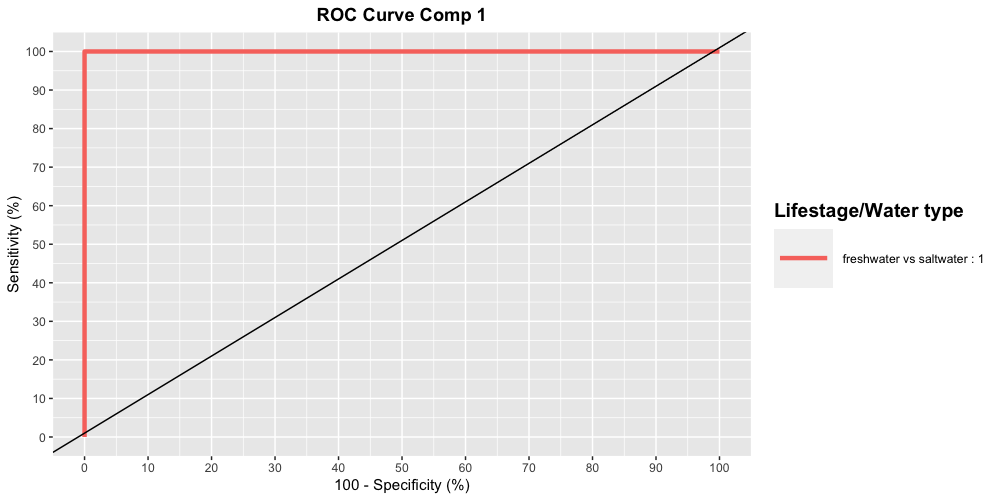

In [34]:
%%R -w 10 -h 5 -u in -r 100

# Create the plot, save the AUC-results in variable
auroc_feed <- auroc(expr_feed.plsda, roc.comp=1, 
                    print=F, plot=T, legend.title='Feed type')

# Create the plot, save the AUC-results in variable
auroc_water <- auroc(expr_water.plsda, roc.comp=1, 
                    print=F, plot=T, legend.title='Lifestage/Water type')

The figure reveals that the **LGG** cancer type has the highest fraction of correctly classified samples vs. all other cancer types, indicating that this model makes mostly successful predictions of whether a sample is the **LGG** cancer type or not. Other cancer types this model predicts well are **GBM** and **PCPG**, which we recognise as the most important cancer types for PC1 in the PCA.

### Other plots

The `plotLoadings()` function displays the loading weights, where colors indicate the class for which the selected variable has a maximal mean value. The function provides a horizontal bar plot to visualise loading vectors. For discriminant analysis, it provides visualisation of highest or lowest mean/median value of the variables with color code corresponding to the outcome of interest.

In [33]:
%%R -w 10 -h 5 -u in -r 100 

# Plotting the loadings on comp 1
plotLoadings(expr_feed.plsda, contrib = 'max', legend.title='Feed type', size.name=0.5, 
             comp=1, title='Maximum mean value\nLoadings on comp 1',
             method = 'mean', size.title = rel(1.25), size.legend=rel(1))

# Plotting the loadings on comp 2
plotLoadings(expr_feed.plsda, contrib = 'max', size.name=0.5, 
             comp=2, title='Loadings on comp 2', legend.title='Feed type', 
             method = 'mean', size.title = rel(1.25), size.legend=rel(1))

R[write to console]: Error in x[name.var, comp] : subscript out of bounds

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In cor(A[[k]], variates.A[[k]]) :
R[write to console]:  the standard deviation is zero

R[write to console]: 2: 
R[write to console]: In cor(A[[k]], variates.A[[k]]) :
R[write to console]:  the standard deviation is zero




Error in x[name.var, comp] : subscript out of bounds


The color assigned can be changed to indicate the class with the minimal mean value:

In [34]:
%%R -w 10 -h 5 -u in -r 100 

# Plotting the loadings on comp 1
plotLoadings(expr_feed.plsda, contrib = 'min', size.name=0.5, legend.title='Feed type',
             comp=1, title='Minimum mean value\nLoadings on comp 1',
             method = 'mean', size.title = rel(1.25), size.legend=rel(1))

# Plotting the loadings on comp 2
plotLoadings(expr_feed.plsda, contrib = 'min', size.name=0.5, 
             comp=2, title='Loadings on comp 2', legend.title='Feed type',
             method = 'mean', size.title = rel(1.25), size.legend=rel(1))

R[write to console]: Error in x[name.var, comp] : subscript out of bounds




Error in x[name.var, comp] : subscript out of bounds


In [35]:
%%R -w 10 -h 5 -u in -r 100 

# Plotting the loadings on comp 1
plotLoadings(expr_water.plsda, contrib = 'max', legend.title='Lifestage/Water',
             comp=1, title='Maximum mean value\nLoadings on comp 1', size.name=0.5,
             method = 'mean', size.title = rel(1.25), size.legend=rel(1))

# Plotting the loadings on comp 2
plotLoadings(expr_water.plsda, contrib = 'max', legend.title='Lifestage/Water',
             comp=2, title='Loadings on comp 2', method = 'mean', 
             size.title = rel(1.25), size.legend=rel(1), size.name=0.5)

R[write to console]: Error in x[name.var, comp] : subscript out of bounds




Error in x[name.var, comp] : subscript out of bounds


The color assigned can be changed to indicate the class with the minimal mean value:

In [36]:
%%R -w 10 -h 5 -u in -r 100 

# Plotting the loadings on comp 1
plotLoadings(expr_water.plsda, contrib = 'min', comp=1, 
             title='Minimum mean value\nLoadings on comp 1', legend.title='Lifestage/Water', 
             method = 'mean', size.title = rel(1.25), size.legend=rel(1), size.name=0.5)

# Plotting the loadings on comp 2
plotLoadings(expr_water.plsda, contrib = 'min', comp=2, size.name=0.5,
             title='Loadings on comp 2',  legend.title='Lifestage/Water', 
             method = 'mean', size.title = rel(1.25), size.legend=rel(1))

R[write to console]: Error in x[name.var, comp] : subscript out of bounds




Error in x[name.var, comp] : subscript out of bounds


A Clustered Image Map including the final gene signature is plotted (default values to Euclidian distance and Complete linkage). The argument `comp` can be also be specified to highlight only the variables selected on specific components.

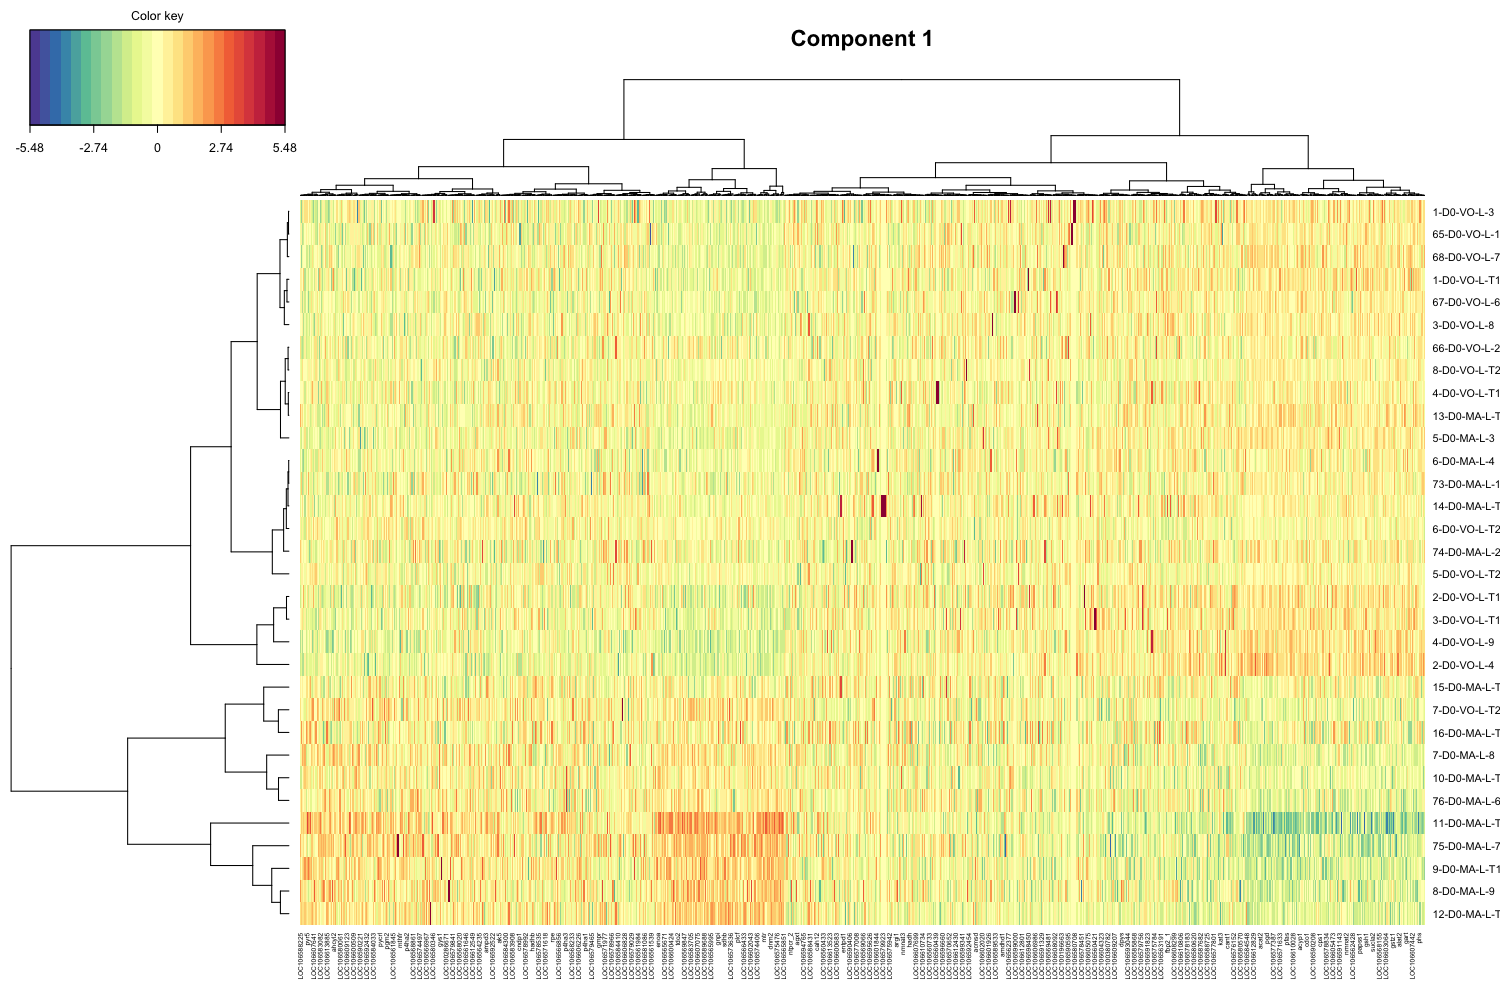

In [37]:
%%R -w 15 -h 10 -u in -r 100

cim(expr_feed.plsda, comp=1, title='Component 1')

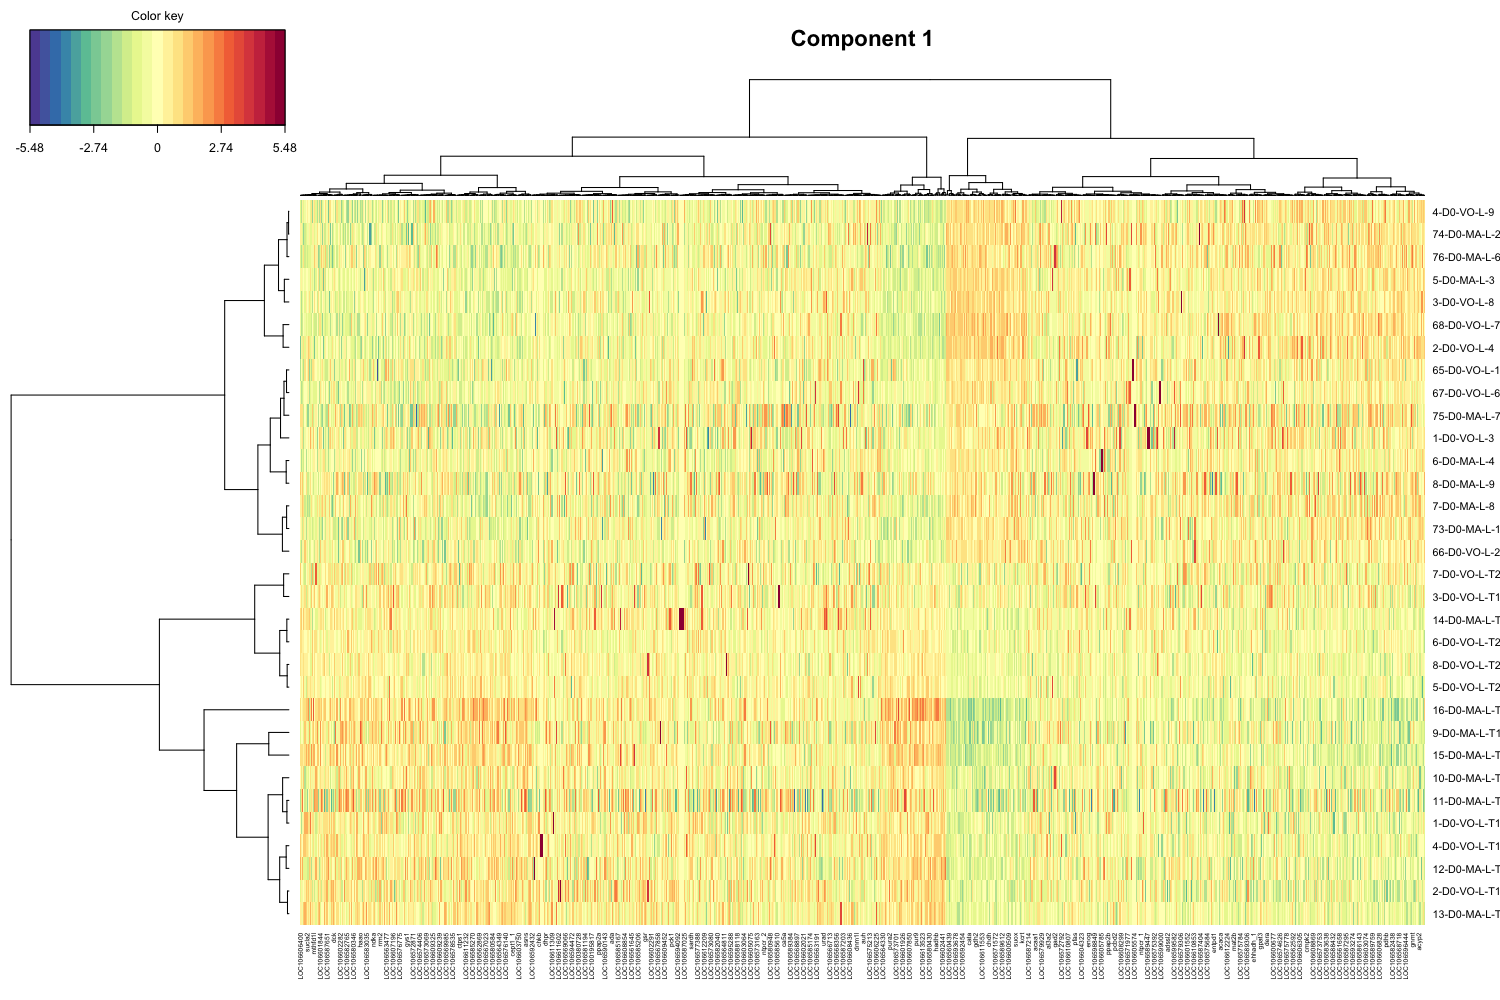

In [38]:
%%R -w 15 -h 10 -u in -r 100

cim(expr_water.plsda, comp=1, title='Component 1')

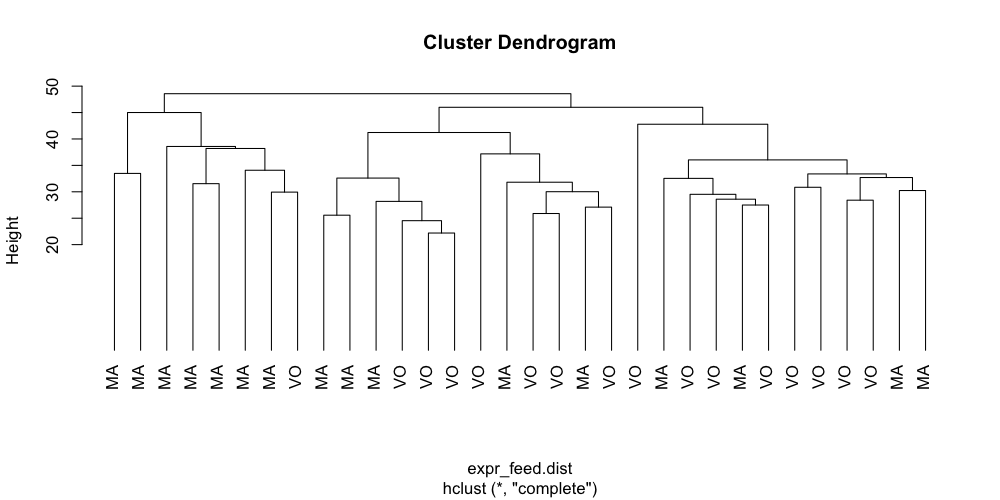

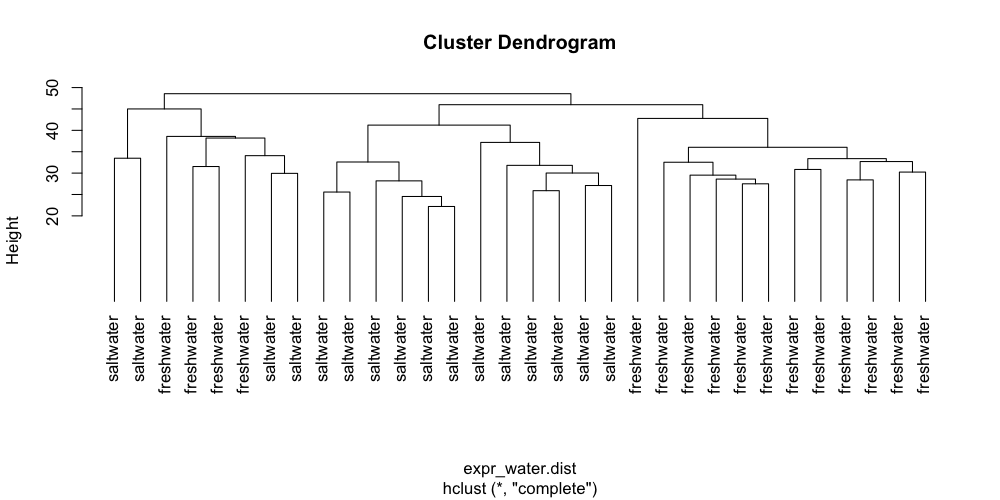

In [41]:
%%R -w 10 -h 5 -u in -r 100

# Define variables
expr_feed.sample <- t(vsd.counts)  # Transposed normalised expression data
expr_feed.group <- classes_feed        # The group vector

expr_water.sample <- t(vsd.counts)  # Transposed normalised expression data
expr_water.group <- classes_water        # The group vector

# Calculate the distance matrix
expr_feed.dist <- dist(expr_feed.sample)
expr_water.dist <- dist(expr_water.sample)


# Perform the hierarchical clustering
expr_feed.hc <- hclust(expr_feed.dist)
expr_water.hc <- hclust(expr_water.dist)

# Plot results
plot(expr_feed.hc, labels = expr_feed.group, 
     hang = -1, cex = 1)

plot(expr_water.hc, labels = expr_water.group, 
     hang = -1, cex = 1)

#### Colouring the samples by group 

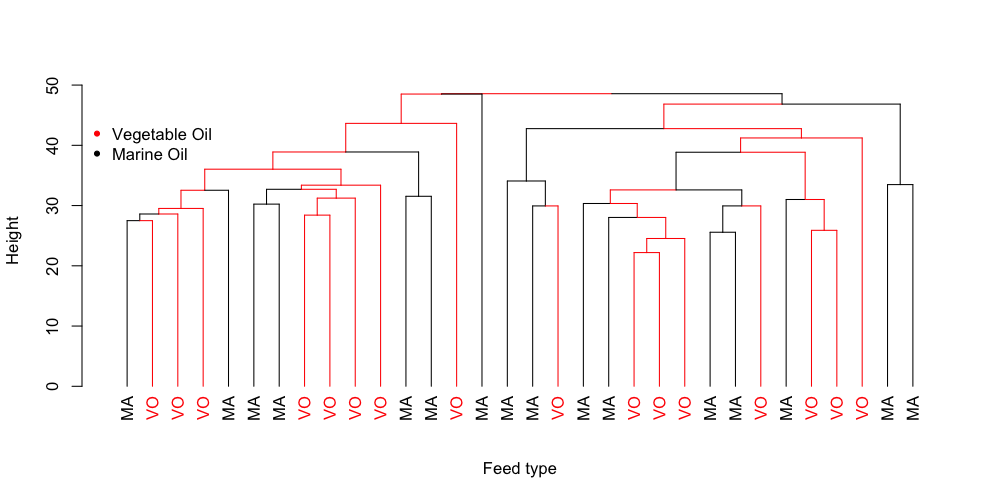

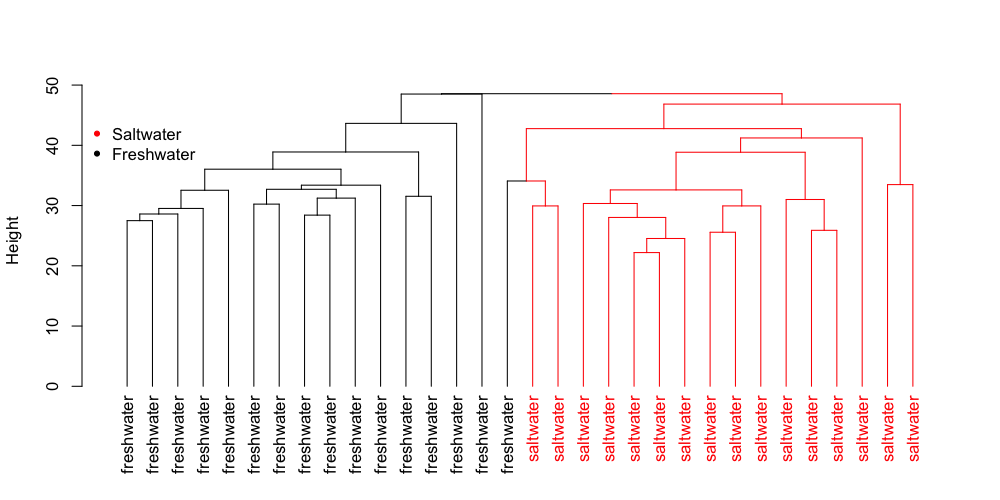

In [42]:
%%R -w 10 -h 5 -u in -r 100 

# Hierarchical clustering of the data with some functions to allow for colouring of the branches according to class
library(cluster)
clust_feed <- diana(expr_feed.sample)
dnd_feed <- as.dendrogram(clust_feed)

clust_water <- diana(expr_water.sample)
dnd_water <- as.dendrogram(clust_water)


# Duplicate rownames aren't allowed, so we need to set the "labels" attributes recursively. We also label inner nodes here. 
rectify_labels <- function(node, df, group){
  newlab <- group[unlist(node, use.names = FALSE)]
  attr(node, "label") <- (newlab)
  return(node)
}

dnd_feed <- dendrapply(dnd_feed, rectify_labels, df = expr_feed.sample, group = expr_feed.group)
dnd_water <- dendrapply(dnd_water, rectify_labels, df = expr_water.sample, group = expr_water.group)

# Creating a color palette as a data.frame with one row for each class, i.e. 2 rows, one for 'Colon' and one for 'Rectum'.
uniqspp_feed <- as.character(unique(expr_feed.group))
colormap_feed <- data.frame(Classes = uniqspp_feed, color = rainbow(n = length(uniqspp_feed)))
colormap_feed[, 2] <- c("black", "red")

uniqspp_water <- as.character(unique(expr_water.group))
colormap_water <- data.frame(Classes = uniqspp_water, color = rainbow(n = length(uniqspp_water)))
colormap_water[, 2] <- c("black", "red")



# Colouring the inner dendrogram edges
color_dendro <- function(node, colormap){
  if(is.leaf(node)){
    nodecol <- colormap$color[match(attr(node, "label"), colormap$Classes)]
    attr(node, "nodePar") <- list(pch = NA, lab.col = nodecol)
    attr(node, "edgePar") <- list(col = nodecol)
  }else{
    spp <- attr(node, "label")
    dominantspp <- levels(spp)[which.max(tabulate(spp))]
    edgecol <- colormap$color[match(dominantspp, colormap$Classes)]
    attr(node, "edgePar") <- list(col = edgecol)
  }
  return(node)
}

dnd_feed <- dendrapply(dnd_feed, color_dendro, colormap = colormap_feed)
dnd_water <- dendrapply(dnd_water, color_dendro, colormap = colormap_water)


# Plotting the dendrogram itself
#par(cex=1) # Reduce font size
plot(dnd_feed, xlab = "Feed type", 
     ylab = "Height", main = "")
legend("topleft", 
       legend = c("Vegetable Oil" , "Marine Oil"), 
       col = c("red", "black"), 
       pch = c(20,20), bty = "n",  pt.cex = 1, cex = 1, 
       text.col = "black", horiz = FALSE, inset = c(0, 0.1))


plot(dnd_water, xlab = "", 
     ylab = "Height", main = "")
legend("topleft", 
       legend = c("Saltwater" , "Freshwater"), 
       col = c("red", "black"), 
       pch = c(20,20), bty = "n",  pt.cex = 1, cex = 1, 
       text.col = "black", horiz = FALSE, inset = c(0, 0.1))


In [43]:
%%R

summary(d_feed[, 1:10])

R[write to console]: Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'object' in selecting a method for function 'summary': object 'd_feed' not found




Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'object' in selecting a method for function 'summary': object 'd_feed' not found


In [50]:
%%R

d.scaled <- scale(d_feed[,-1], center = TRUE, scale = TRUE)
summary(d.scaled[, 1:10])

   106603558         100194765         100196673           100194631      
 Min.   :-1.5442   Min.   :-2.4006   Min.   :-2.045400   Min.   :-1.0309  
 1st Qu.:-0.7902   1st Qu.:-0.3686   1st Qu.:-0.772911   1st Qu.:-1.0309  
 Median :-0.0565   Median : 0.1702   Median :-0.009783   Median : 0.5754  
 Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.000000   Mean   : 0.0000  
 3rd Qu.: 0.4770   3rd Qu.: 0.4962   3rd Qu.: 0.684464   3rd Qu.: 0.6431  
 Max.   : 3.0122   Max.   : 1.8129   Max.   : 2.589462   Max.   : 2.6967  
                                                                          
   106603694     106603750         106603838         106603918      
 Min.   : NA   Min.   :-2.9692   Min.   :-1.2148   Min.   :-2.7852  
 1st Qu.: NA   1st Qu.:-0.2038   1st Qu.:-0.9694   1st Qu.:-0.4792  
 Median : NA   Median :-0.1489   Median : 0.3447   Median :-0.0367  
 Mean   :NaN   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: NA   3rd Qu.: 0.6052   3rd Qu.: 0.6356   3rd 

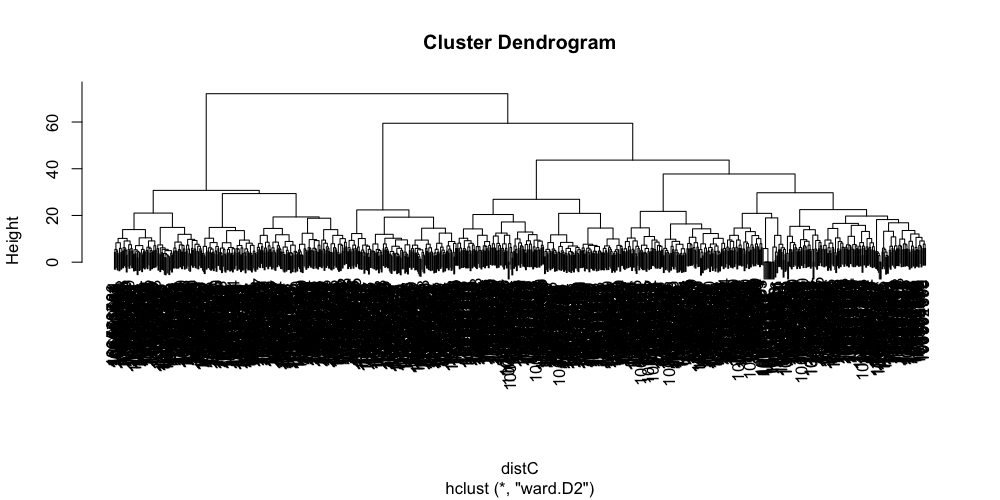

In [51]:
%%R -w 10 -h 5 -u in -r 100 

distC <- dist(na.omit(t(d.scaled)))
distC

treeC <- hclust(d=distC, method = "ward.D2")
plot(treeC)


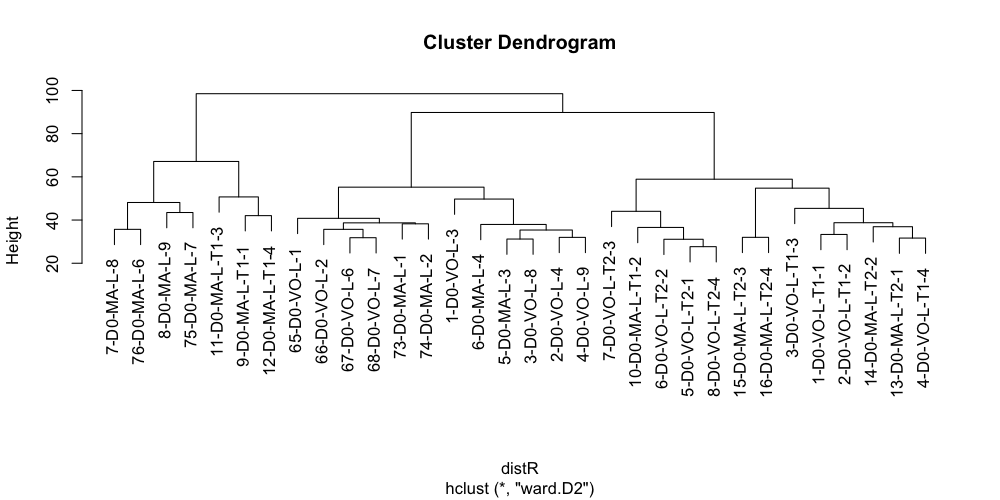

In [52]:
%%R -w 10 -h 5 -u in -r 100

distR <- dist(d.scaled)
treeR <- hclust(d=distR, method = "ward.D2")
plot(treeR)

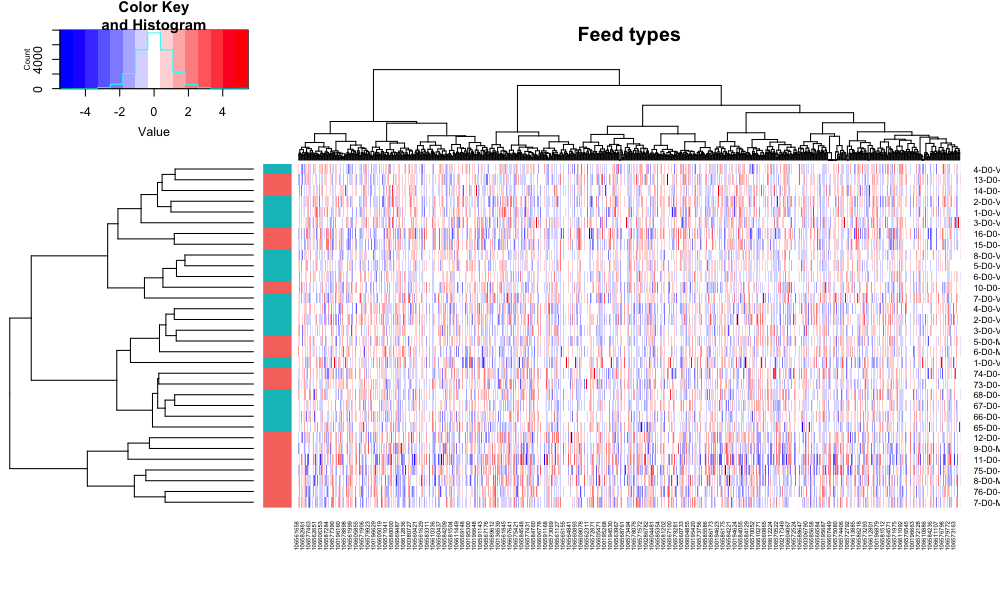

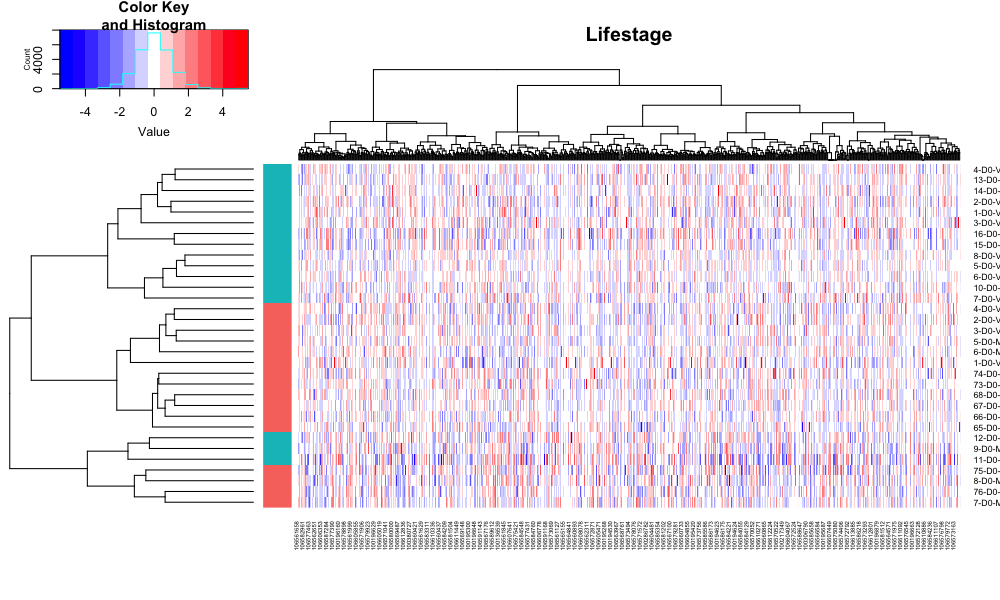

In [53]:
%%R -w 10 -h 6 -u in -r 100 

clrs_feed <- c("#F8766D","#00BFC4")[d_feed$Feed]

suppressMessages(library(gplots))

heatmap.2(x = as.matrix(d.scaled), 
          Colv = as.dendrogram(treeC),
          Rowv = as.dendrogram(treeR),
          trace = "none",
          col = colorRampPalette(c("blue","white","red")),
          RowSideColors = clrs_feed,
          labCol = NULL,
          #srtCol = 45,
          cexRow = 0.8,
          margins = c(7,3),
          main = "Feed types"
)


clrs_water <- c("#F8766D","#00BFC4")[d_water$Water]
heatmap.2(x = as.matrix(d.scaled), 
          Colv = as.dendrogram(treeC),
          Rowv = as.dendrogram(treeR),
          trace = "none",
          col = colorRampPalette(c("blue","white","red")),
          RowSideColors = clrs_water,
          labCol = NULL,
          #srtCol = 45,
          cexRow = 0.8,
          margins = c(7,3),
          main = "Lifestage"
)